# Transfer learning


Reference:

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/


**Environment:**

- Python 3.6
- Keras-gpu 2.2.0
- matplotlib 2.2.2
- pillow 5.1.0

# Build a base model

In [1]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image   # for load_image
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

Using TensorFlow backend.


# Freeze layers from pretrained model

In [2]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001C8151DB860> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB01E80> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB01F98> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C81BB01FD0> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB3A470> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB3AC88> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C81BB75E10> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB64C18> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BB8AA20> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BBA1B70> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C81BBB4160> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BBC6F98> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BC05780> False
<keras.layers.convolutional.Conv2D object at 0x000001C81BBEE438> False
<ker

# Create a new model

In [3]:
# from keras import models
# from keras import layers
# from keras import optimizers
 
targetClassNumber = 11   
    
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(targetClassNumber, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                11275     
Total params: 40,417,099
Trainable params: 32,781,835
Non-trainable params: 7,635,264
_________________________________________________________________


# Setup the data generators

In [4]:
train_dir = './train'
validation_dir = './validation'
image_size = 224
 
# nTrain = 600
# nVal = 150

# from keras.preprocessing.image import ImageDataGenerator
# import numpy as np
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Label dictionary of train images
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 33 images belonging to 11 classes.
Found 22 images belonging to 11 classes.
{'Benjamin': 0, 'Damarcus': 1, 'Frank': 2, 'Lokesh': 3, 'Misael': 4, 'Sohail': 5, 'aaron': 6, 'albert': 7, 'brian': 8, 'mooyoung-lee': 9, 'vivek': 10}


# Save image labels

### as a pickle file to look up during prediction step

In [5]:
# import pickle
# with open('labels.pickle', 'wb') as f:
#     pickle.dump(class_dictionary, f)

In [5]:
import json

with open('label_dict.txt', 'w') as file:
     file.write(json.dumps(class_dictionary)) # use `json.loads` to do the reverse

# Train the model


In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=24,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('faceID_VGG16.h5')

Epoch 1/24
2/1 [====================================] - 9s 5s/step - loss: 3.7111 - acc: 0.0625 - val_loss: 2.6065 - val_acc: 0.1364
Epoch 2/24
2/1 [====================================] - 2s 906ms/step - loss: 2.6819 - acc: 0.0983 - val_loss: 2.0295 - val_acc: 0.2727
Epoch 3/24
2/1 [====================================] - 2s 910ms/step - loss: 2.2681 - acc: 0.2411 - val_loss: 1.5867 - val_acc: 0.6818
Epoch 4/24
2/1 [====================================] - 2s 882ms/step - loss: 1.9260 - acc: 0.3661 - val_loss: 1.3109 - val_acc: 0.5455
Epoch 5/24
2/1 [====================================] - 2s 881ms/step - loss: 1.4979 - acc: 0.4643 - val_loss: 1.2906 - val_acc: 0.5455
Epoch 6/24
2/1 [====================================] - 2s 882ms/step - loss: 1.3901 - acc: 0.5091 - val_loss: 0.8115 - val_acc: 0.8182
Epoch 7/24
2/1 [====================================] - 2s 884ms/step - loss: 1.2515 - acc: 0.6071 - val_loss: 0.6109 - val_acc: 0.9091
Epoch 8/24
2/1 [===================================

# Check Performance

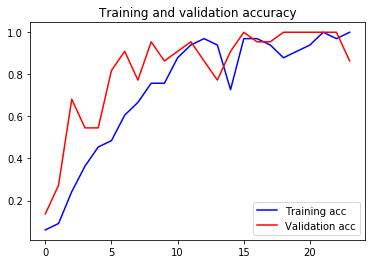

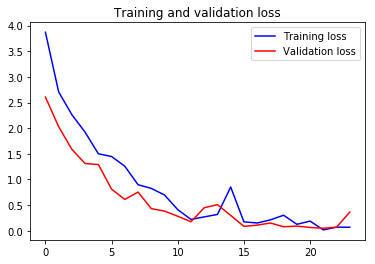

In [7]:
# %matplotlib inline
# import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Found 22 images belonging to 11 classes.
2/1 [======================================================] - 1s 403ms/step
No of errors = 3/22


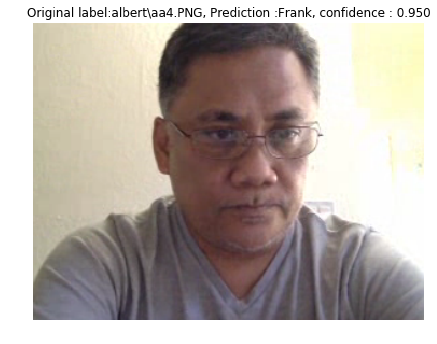

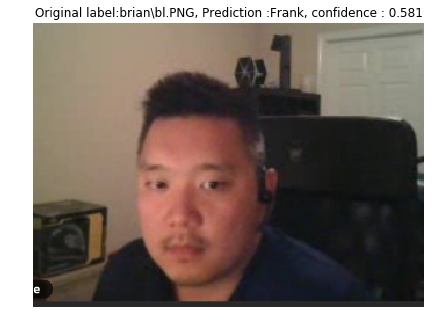

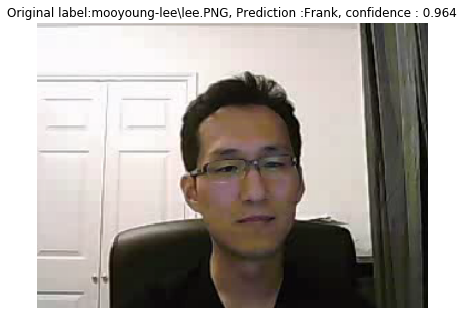

In [8]:
# from keras.preprocessing import image   # for load_image

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, 
                                      steps=validation_generator.samples/validation_generator.batch_size,
                                      verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()